# Get Dataset

In this notebook we get and analyze the input dataset for the model.

We download text available in [Refranero Castellano website](https://www.refranerocastellano.com/).

In [1]:
import asyncio
import re
import string

import aiohttp
import pandas as pd
from lxml import etree

In [2]:
base_url = "https://www.refranerocastellano.com/"

async def get_xtree(url, session):
    """Build XPath queryable tree from URL content."""
    response = await session.request(method="GET", url=url)
    body = await response.text()
    tree = etree.fromstring(body, parser=etree.HTMLParser())
    return tree

def num_words(s):
    return len(s.split())

## Download text

In [3]:
refs = set()

async with aiohttp.ClientSession() as session:
    tree = await get_xtree(base_url, session)
    pages = tree.xpath("//div[@id='caja-f1']/a/@href")
    for subtree in await asyncio.gather(*[get_xtree(f"{base_url}{p}", session) for p in pages]):
        # TODO follow links.
        texts = subtree.xpath("//p/text()")
        for text in texts:
            # normalize.
            text = " ".join(text.lower().replace("-", " ").split())
            text = re.sub(r"[^\w\s]", "", text)
            if text:
                refs.add(text)

len(refs)

8283

## Keep only samples of some length

In [4]:
srefs = sorted(refs, key=lambda s: num_words(s))

# drop short and long texts.
i = 3
j = 18
srefs = [r for r in srefs if i < num_words(r) < j]

len(srefs)

7787

In [5]:
srefs[:10] + srefs[-10:]

['a dios llamaron tú',
 'palabras no sacan sangre',
 'viejo que boda hace',
 'buen servicio mal galardón',
 'buey viejo surco derecho',
 'hija desposada hija enajenada',
 'pascua deseada pronto pasada',
 'buey frontudo caballo cascudo',
 'joven madrugador viejo trasnochador',
 'libro cerrado maestro callado',
 'a la mujer y al can el palo de una mano y de la otra el pan',
 'los jardines de valencia la nobleza de madrid trigo de valladolid y de los sabios la ciencia',
 'adiós puente de tudela por debajo pasa el ebro por encima los franceses que van al degolladero',
 'para el refranero diciembre ya es tarde para la siembra santa lucía es el 13 de diciembre',
 'si da el cántaro en la piedra o la piedra en el cántaro mal para el cántaro',
 'tres cosas demando de dios si me las diese la tela el telar y la que teje',
 'también se puede utilizar la harina de castañas para preparar pan pan de castañas pasteles y pasta',
 'al que tiene mujer hermosa o castillo en frontera o viña en carretera nu

## Save dataset

In [6]:
with open("dataset.txt", "w") as f:
    f.write("\n".join(srefs))

## Distribution of number of words

<AxesSubplot:ylabel='Frequency'>

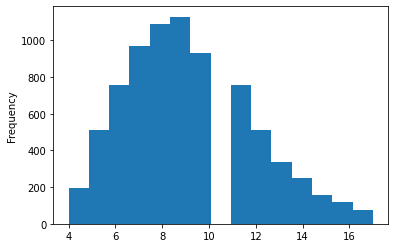

In [7]:
pd.Series([num_words(r) for r in srefs]).plot.hist(bins=j-i)

## Vocabulary size and distribution

In [8]:
all_words = [word for text in srefs for word in text.split()]
len(all_words)

70740

In [9]:
from collections import Counter

vocab = Counter(all_words)
len(vocab)

7681

<AxesSubplot:>

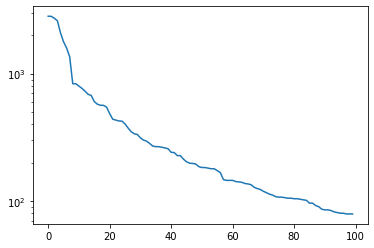

In [10]:
words, freqs = zip(*vocab.most_common())
pd.Series(freqs[:100]).plot.line(logy=True)